best_x: [ 0.124094  0.80296  -0.660644] 
 best_y: [-0.]


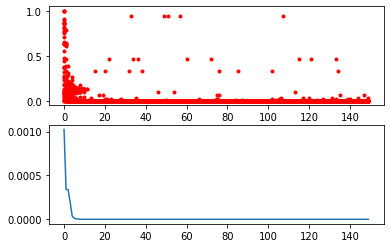

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from sko.GA import GA
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.metrics import confusion_matrix as cm, classification_report as cr

from sklearn.preprocessing import MinMaxScaler as MinMax

np.set_printoptions(precision = 6, suppress = True)


def schaffer(p0,p1,p2):
    '''
    This function has plenty of local minimum, with strong shocks
    global minimum at (0,0) with value 0
    '''
    x1, x2, x3 = p0, p1, p2
    x = np.square(x1) + np.square(x2) + p2
    return 0.5 + (np.square(np.sin(x)) - 0.5) / np.square(1 + 0.001 * x)


ga = GA(func=schaffer, n_dim=3, size_pop=50, max_iter=150, lb=[-1, -1, -1], ub=[1, 1, 1], precision=1e-7)
best_x, best_y = ga.run()
print('best_x:', best_x, '\n', 'best_y:', best_y)

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(2, 1)
ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.show()

In [2]:
data = pd.read_csv('C:/Users/XRUI/Desktop/data.csv', index_col = None)

In [3]:
#随机抽取75%的样本进行交叉验证
def sample(data):
    origin = range(len(data))
    train = random.sample(origin, int(len(data) * 0.75))
    test = list(set(origin) - set(train))
    
    ndata = np.array(data.drop('NO.', axis = 1))
    scaler = MinMax()
    scaler.fit(ndata)
    ndata = scaler.transform(ndata)
    train_x = ndata[train][...,0:4]
    train_y = ndata[train][...,4]
    test_x = ndata[test][..., 0:4]
    test_y = ndata[test][..., 4]
    return train_x, train_y, test_x, test_y, scaler

In [4]:
"""
    设定遗传算法种群规模为 60，进化次数为150 次，交叉概率为0.65，变异概率为0.025。
    设定初始网络参数的迭代次数为5000 次，学习率为0.025，训练目标为0.00001。
"""

mlp = MLP(hidden_layer_sizes = 50, activation = 'logistic', solver = 'sgd', learning_rate = 'adaptive',
    learning_rate_init = 0.025, max_iter = 5000, tol = 1e-5)
while (True):
    train_x, train_y, test_x, test_y, scaler = sample(data)
    mlp.fit(train_x, train_y)
    score = mlp.score(test_x, test_y)
    if (score > 0.82):
        print(score)
        break

predict = mlp.predict(test_x)
origin_help = scaler.inverse_transform(np.c_[test_x, predict])
origin_test = scaler.inverse_transform(np.c_[test_x, test_y])
pdata = pd.DataFrame(np.c_[origin_help[...,4], origin_test[...,4], origin_help[...,4]-origin_test[...,4]], columns = ['预测', '真实', '差值'])

0.822761123406236


In [5]:
def AAD(predict, real):
    mean = real.mean()
    sum = 0
    for data_p, data_r in predict, real:
        sum += abs(data_p - data_r) / mean
    return sum / real.size * 100

def RMSD(predict, real):
    sum = 0
    for data_p, data_r in predict, real:
        sum += (data_p - data_r)**2
    return np.sqrt(sum / real.size)

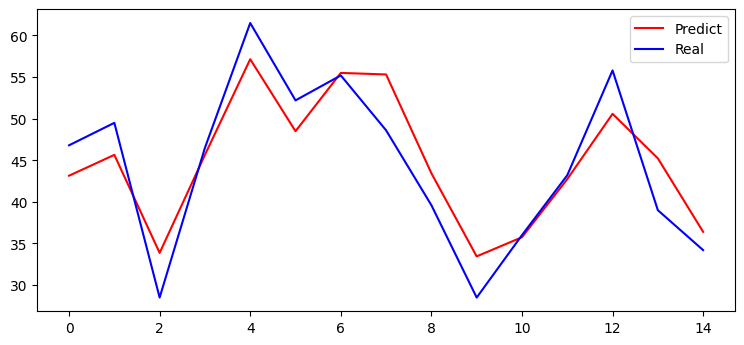

In [6]:
plt.figure(figsize = (9,4), dpi = 100)
plt.plot(pdata.index, pdata['预测'], color = 'r', label = 'Predict')
plt.plot(pdata.index, pdata['真实'], color = 'b', label = 'Real')
plt.legend()
plt.show()

In [7]:
pdata

,预测,真实,差值
0,43.146441,46.8,-3.653559
1,45.650472,49.5,-3.849528
2,33.866526,28.5,5.366526
3,45.650472,46.5,-0.849528
4,57.148110,61.5,-4.351890
5,48.495441,52.2,-3.704559
6,55.501262,55.2,0.301262
7,55.314340,48.6,6.714340
8,43.438779,39.6,3.838779
9,33.448468,28.5,4.948468


In [8]:
np.mean(pdata['差值'])

0.4835388434210898

In [9]:
papper_x = np.array([[4000, 72.5,9.8,-10,0]])
papper_x = scaler.transform(papper_x)
papper_x = papper_x[...,0:4]
predict_y = scaler.inverse_transform(np.c_[papper_x, mlp.predict(papper_x)])
predict_y

array([[4000.     ,   72.5    ,    9.8    ,  -10.     ,   59.50756]])

In [10]:
result = pd.DataFrame(np.r_[predict_y, [[4000, 72.5, 9.8, -10, 59.89]]].T, \
             index = ['P', 'Vf', 'Vs', 'D', 'Rd'], columns = ['复现数据', '论文数据'])
result['差值'] = result['复现数据'] - result['论文数据']
result['相对误差'] = abs(result['差值'])/result['论文数据']
result

,复现数据,论文数据,差值,相对误差
P,4000.00000,4000.00,0.00000,0.000000
Vf,72.50000,72.50,0.00000,0.000000
Vs,9.80000,9.80,0.00000,0.000000
D,-10.00000,-10.00,0.00000,-0.000000
Rd,59.50756,59.89,-0.38244,0.006386


In [11]:


def AAD(predict, real):
    mean = real.mean()
    sum = 0
    for i in range(real.size):
        sum += abs(predict[i] - real[i]) / mean
    return sum / real.size * 100

def RMSD(predict, real):
    sum = 0
    for i in range(real.size):
        sum += (predict[i] - real[i])**2
    return np.sqrt(sum / real.size)

In [12]:
predict = np.array(pdata['预测'])
real = np.array(pdata['真实'])

In [14]:
predict = np.array([38.560604,
                   40.094823,
                   39.916437,
                   44.197501,
                   56.990120,
                   55.601426,
                    45.628096,
                    33.544105,
                    36.017391,
                    42.379183,
                    40.478124,
                    45.288863,
                    50.876794,
                    45.474939,
                    45.474939
                   ])
#predict = np.round(predict)
real = np.array([33.0,
                39.1,
                39.6,
                45.0,
                61.5,
                55.2,
                46.5,
                28.5,
                36.0,
                43.2,
                39.0,
                39.0,
                55.8,
                51.0,
                52.5])
print(AAD(predict, real), RMSD(predict, real))

6.7047978643405015 3.880566356969259


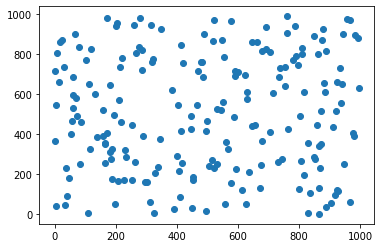

In [4]:
import matplotlib.pyplot as plt
import random
plt.scatter(random.sample(range(0,1000), 200), random.sample(range(0,1000), 200))
plt.show()

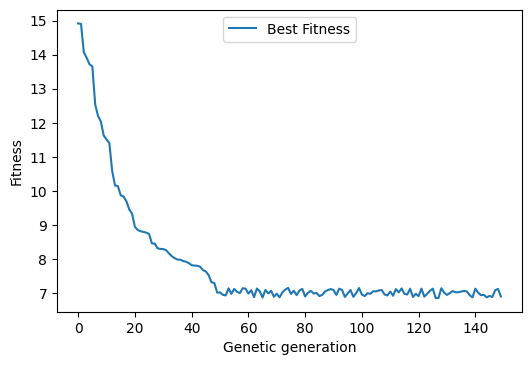

In [51]:
x = range(0,150)
y = sorted([random.uniform(15,9) for i in range(0,20)], reverse = True)
y += sorted([random.uniform(9,8) for i in range(20,35)], reverse = True)
y += sorted([random.uniform(8,7) for i in range(35,50)], reverse = True)
y += [random.uniform(6.85, 7.15) for i in range(50,150)]

plt.figure(figsize = (6,4), dpi = 100)
plt.plot(x, y)
plt.ylabel('Fitness')
plt.xlabel('Genetic generation')
plt.legend(['Best Fitness'], loc = 'upper center')
plt.show()

In [75]:
x = (1,)
type(x)

tuple

In [11]:
from scipy import interpolate
from scipy.interpolate import lagrange

In [10]:
x = [1.0,2.0,3.0,4.0,6.0]
y = [16.0,8.0,16.0,20.0,38.0]


20.39999999999965

In [25]:
result = []
result.append(lagrange(x, y)(5.0))
result.append(interpolate.interp1d(x,y)(5.0))
result.append(interpolate.UnivariateSpline(x,y)(5))
result


[20.39999999999965, array(29.), array(28.05625256)]